In [1]:
%%HTML

<link rel="stylesheet" href="rise.css"/>  

In [10]:
import simpeg.electromagnetics.time_domain as tdem
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0

from geoana.em.tdem import simple_functions

from ipywidgets import interact, IntSlider, FloatSlider, FloatLogSlider

from IPython.display import IFrame, Image
from base64 import b64decode

from image_data import profile_slice_frames, time_slice_frames, inv_slice_frames

In [3]:
h = [10, 10]
background_cond = 0.001
layer_cond = 0.1
sigma = [background_cond, layer_cond, background_cond]

ts = np.logspace(-6, -1, 256)

rx = tdem.receivers.PointMagneticFluxTimeDerivative(locations=[0, 0, 0], times=ts)

#waveform = tdem.sources.RampOffWaveform(2.5E-6)
waveform = tdem.sources.StepOffWaveform()
src = tdem.sources.CircularLoop(rx, location=[0, 0, 0], radius=35, waveform=waveform)

srv = tdem.Survey(src)

sim = tdem.Simulation1DLayered(srv, thicknesses=h, sigma=sigma)

In [4]:
def app_cond_late_time(v, t, moment):
    temp = v**2 * t**5 / (moment**2 * mu_0**5) * 20**2
    return temp**(1/3) * np.pi

def do_bz2_plot(top_cond, layer_cond, back_cond, top_layer_thick, middle_layer_thick):

    ts = sim.survey.source_list[0].receiver_list[0].times
    
    sim.sigma = [top_cond, layer_cond, back_cond]
    sim.thicknesses = [top_layer_thick, middle_layer_thick]
    v_sim = -sim.dpred(None)
    v_half_top = -simple_functions.vertical_magnetic_flux_time_deriv_horizontal_loop(
        ts, sigma=top_cond, radius=src.radius
    )
    v_half_bot = -simple_functions.vertical_magnetic_flux_time_deriv_horizontal_loop(
        ts, sigma=back_cond, radius=src.radius
    )
    app_cond = app_cond_late_time(v_sim, ts, src.moment)
    
    fig, axs = plt.subplots(1, 2, sharex=True)
    ax = axs[0]
    ax.loglog(ts, v_sim)
    ax.loglog(ts, v_half_top)
    ax.loglog(ts, v_half_bot)
    
    ax = axs[1]
    ax.loglog(ts, app_cond)
    ax.axhline(top_cond, color='C1')
    ax.axhline(back_cond, color='C2')


# TDEM Interpretation

* Simple interpretation examples
* Inversion techniques


## Simple Interpretations

From before:

* Late-time apparent conductivity for central-loop soundings:
$$
\sigma_{app, late} = \frac{20^{2/3}V^{2/3} \pi t^{5/3}}{M^{2/3} \mu_0^{5/3}}
$$

### Layered Earth
* For central loop soundings
* Essentially transitions between the different asymptotic values at late time

In [5]:
gen_sigma_slider = lambda : FloatLogSlider(1E-3, min=-5, max=1)
gen_thick_slider = lambda : FloatLogSlider(1E2, min=0, max=4)
out = interact(
    do_bz2_plot,
    top_cond=gen_sigma_slider(),
    layer_cond=gen_sigma_slider(),
    back_cond=gen_sigma_slider(), 
    top_layer_thick=gen_thick_slider(),
    middle_layer_thick=gen_thick_slider()
);

interactive(children=(FloatLogSlider(value=0.001, description='top_cond', max=1.0, min=-5.0), FloatLogSlider(v…

### Burried conductive cylinder

In [23]:
interact(lambda frame: Image(b64decode(profile_slice_frames[frame])), frame=IntSlider(min=0, max=11, value=0));

interactive(children=(IntSlider(value=0, description='frame', max=11), Output()), _dom_classes=('widget-intera…

In [15]:
interact(lambda frame: Image(b64decode(time_slice_frames[frame])), frame=IntSlider(min=0, max=len(time_slice_frames)-1, value=0));

interactive(children=(IntSlider(value=0, description='frame', max=38), Output()), _dom_classes=('widget-intera…

## Inversions
### 1D layered inversions

Like any sounding based methodology, the simplest inversion is usually a 1D layered half-space inversion:

* It can be parametric (inverting for few layers):

<div class="row">
<div class="column">

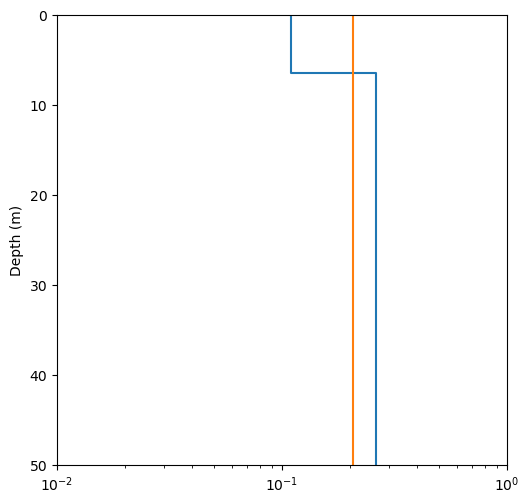

</div>
<div class="column">

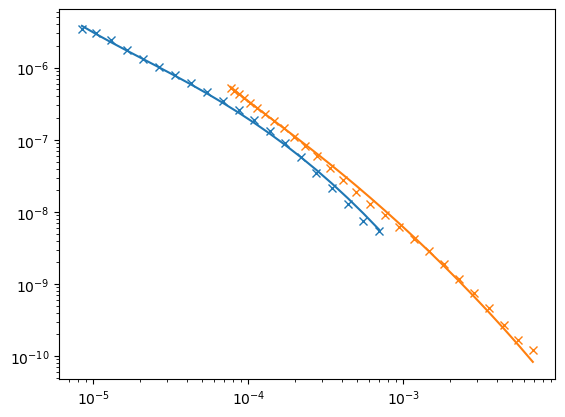

</div>
</div>

* Or generalized to many layers:

<div class="row">
<div class="column">

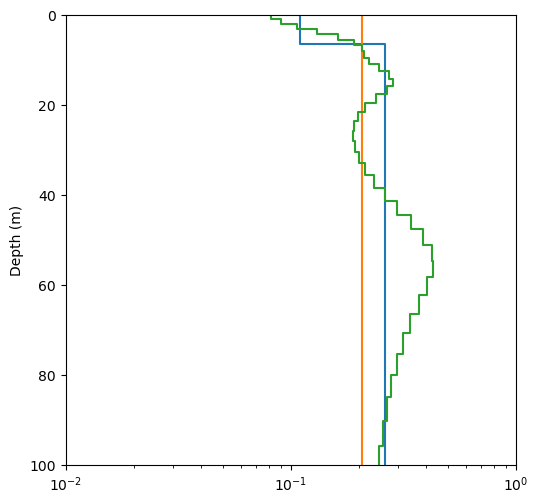

</div>
<div class="column">

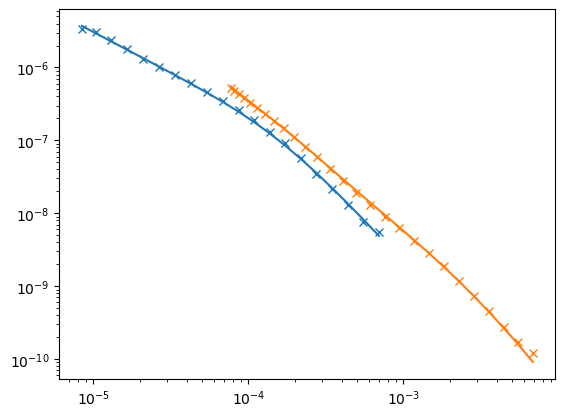
</div>
</div>

### Multiple soundings:

If there are many soundings, the first steps (usually) are:
* Invert each independently
* Stitch the results together in 3D


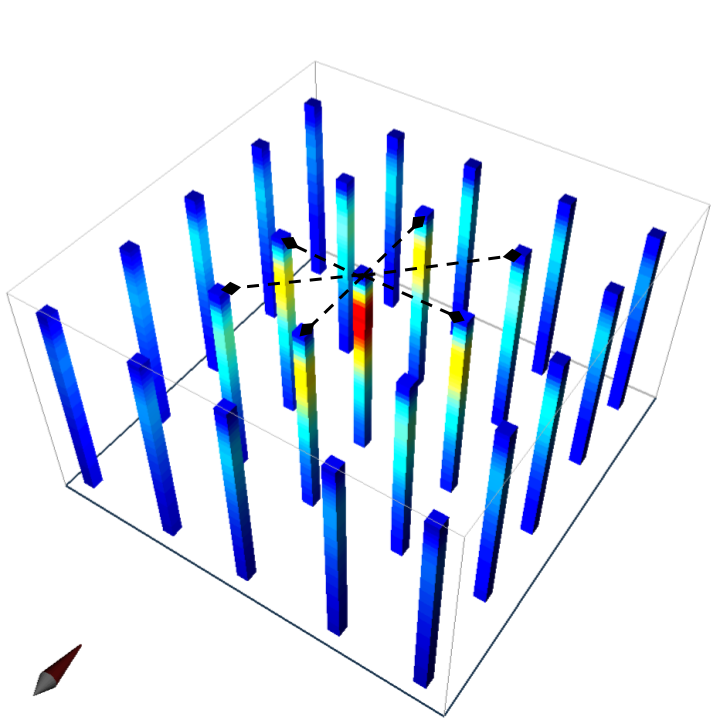

In [17]:
interact(lambda frame: Image(b64decode(inv_slice_frames[frame])), frame=IntSlider(min=0, max=12, value=0));

interactive(children=(IntSlider(value=0, description='frame', max=12), Output()), _dom_classes=('widget-intera…

### Higher dimensional inversion techniques
3D time-domain inversion is "hard"

Need to solve this PDE for full 3D modelling:

$$
\nabla \mu^{-1} \nabla \vec{E} + \sigma \frac{\partial \vec{E}}{\partial t} = \frac{\partial\vec{s}_e(t)}{\partial t}
$$

Need to:

* Discretize this PDE:
    * Approximate Curls
    * Approximate time derivatives:
        * Time step the solution
        * Backwards Euler (usually)
* Solve the discrete system
    * Airborne suverys usually large spatially
    * Many unique source locations (Solve the entire PDE for *EACH* source)
* A single forward operation for one source can take upwards of 1 hour!
* 3D Inversions requires **many** **complete** forward operations.

### Laterally constrained inversions

> **Idea**: Approximate the physics in a 3D inversion with 1D EM physics

* Usually a "decent" approximation to 3D inversion
* Like "stitching" during the inverse process.

> **Essentially** Use the results of nearby inversions as a reference model!

#### Local Scale
Water evaluation in a field:

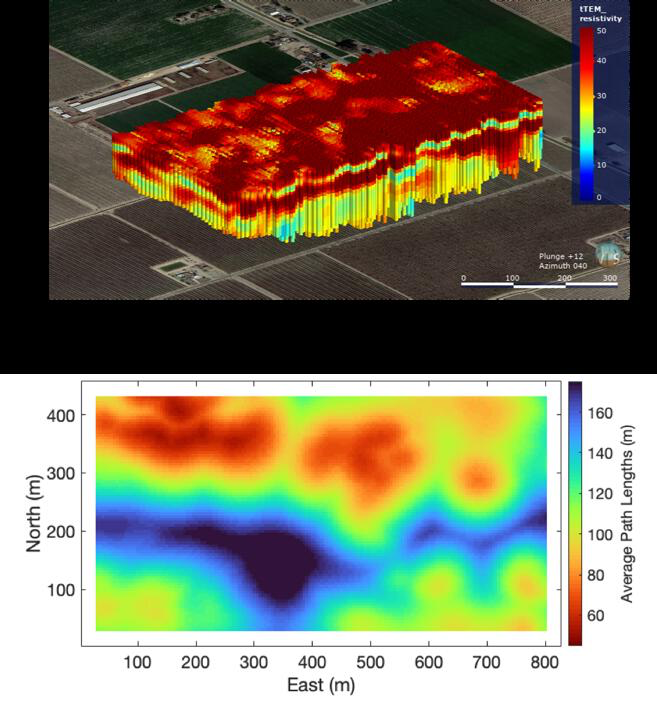

From https://doi.org/10.1190/image2022-3746381.1

#### Regional Scale
Example from Northern California
* Looking at salt water encroachment
* Airborne VTEM data

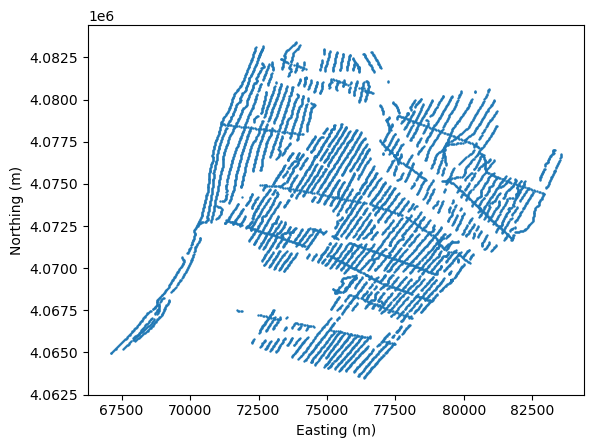

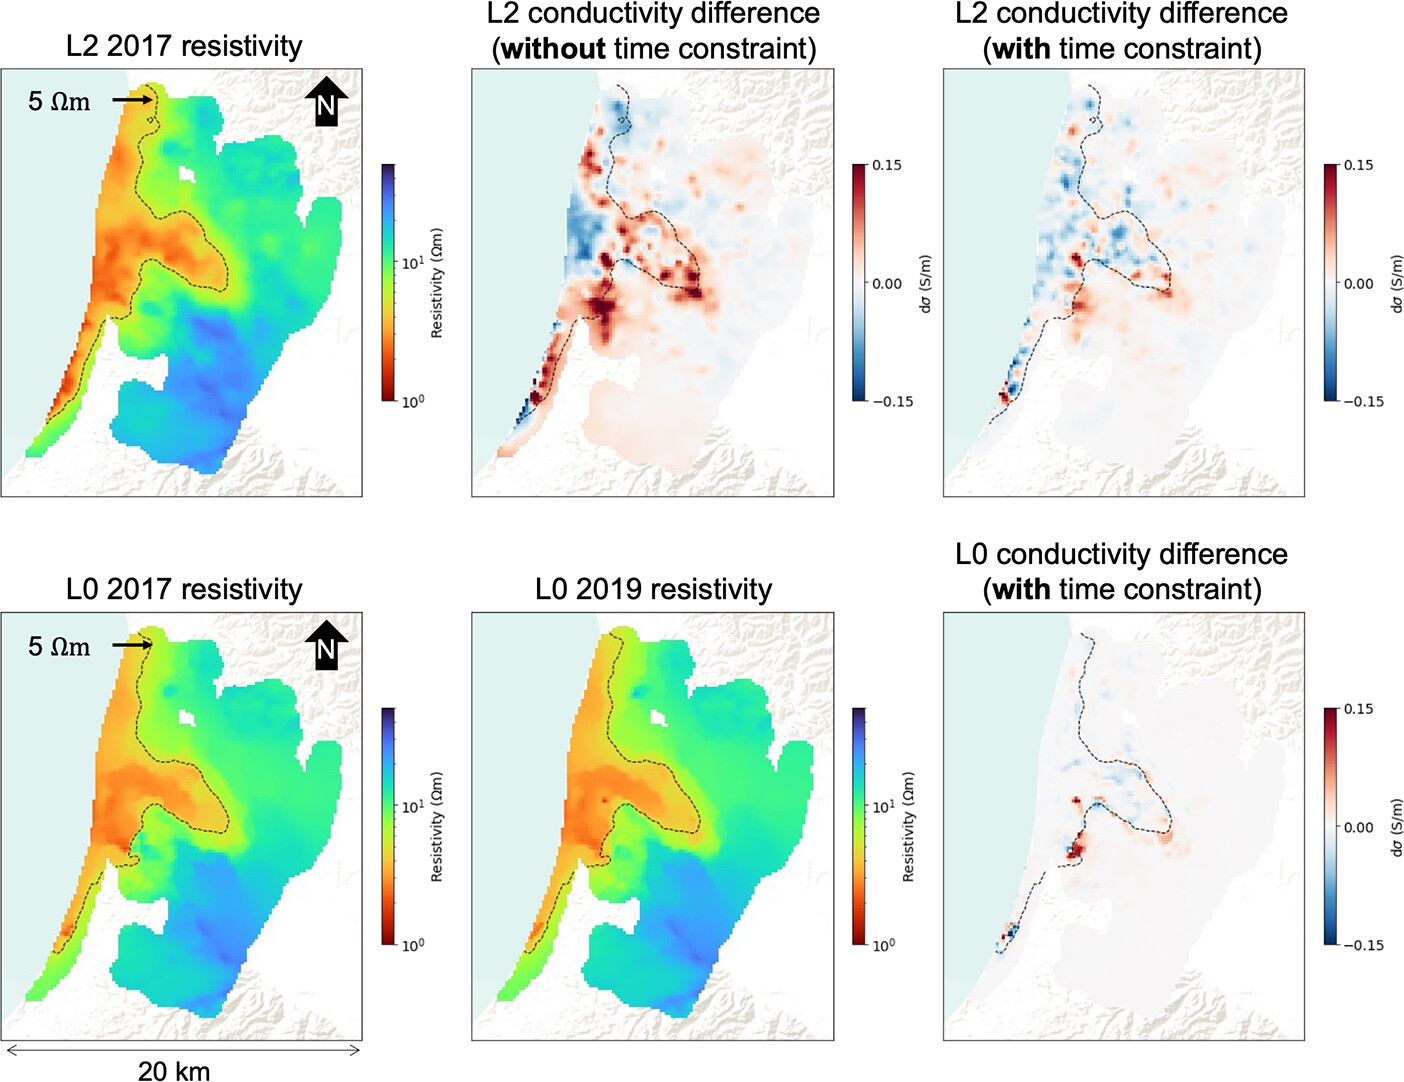

From: https://doi.org/10.1190/tle43020084.1

## Case Studies:

> from https://em.geosci.xyz

* Albany TDEM [here](https://em.geosci.xyz/content/case_histories/albany/index.html#albany-index)
    * Airborne VTEM
    * Ground TDEM 
    * 3D Inversion!
    * Searching for conductive graphite anomaly

* Aspen TDME [here](https://em.geosci.xyz/content/case_histories/aspen/index.html)
    * SAGD Monitoring
    * Resistive oil target
    * Laterally Constrained Inversions
    * 3D inversion